# Predicting US Domestic Avocado Prices

Our goal is to build at least three models to predict the average US domestic Avocado price based on <a href="https://www.kaggle.com/neuromusic/avocado-prices/home">historical data available on Kaggle</a> originating from the <a href="http://www.hassavocadoboard.com/retail/volume-and-price-data">Haas Avocado Board</a>. 

The resulting models will be stacked in order to demonstrate the power of ensemble models in a subsequent notebook. 

## Description of the dataset

The data represent weekly retail scan data for National retail volume (units) and price for an approximately 3-year period beginning in January 2015. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. 

The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

<ul>
<li>Date - The date of the observation
<li>AveragePrice - the average price of a single avocado
<li>type - conventional or organic
<li>year - the year
<li>Region - the city or region of the observation
<li>Total Volume - Total number of avocados sold
<li>4046 - Total number of avocados with PLU 4046 sold
<li>4225 - Total number of avocados with PLU 4225 sold
<li>4770 - Total number of avocados with PLU 4770 sold
</ul>

## Comment on modeling approaches

This is a very rich dataset with a lot of possibilities for some interesting modeling approaches. We will start by constructing models that will take the average price across the US as the Y variable, and we will restrict our attention to the use of time-related variables as features of  X. Later, we might try to incorporate prior regional pricing and sales volume data at prior times. 



  

In [1]:
## Library imports
import math
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from fbprophet import Prophet

%matplotlib inline

## Data Exploration and Cleaning

In [2]:
data = pd.read_csv("avocado.csv")
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
## All we need are the Date and the 'AveragePrice' of type 'conventional' avocados for the 'TotalUS' region 
data_reduced = data.loc[ ( data['region']=='TotalUS' ) & ( data['type']=='conventional' ) ].copy()[['Date', 'year', 'AveragePrice']]

In [4]:
data_reduced = data_reduced.sort_values(['Date'], ascending=['True'])

In [5]:
data_reduced.reset_index(drop=True, inplace=True)

In [6]:
# Let's get a sense of what's here
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 3 columns):
Date            169 non-null object
year            169 non-null int64
AveragePrice    169 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.0+ KB


In [7]:
data_reduced.describe()

,year,AveragePrice
count,169.000000,169.000000
mean,2016.147929,1.092012
std,0.942709,0.174119
min,2015.000000,0.760000
25%,2015.000000,0.970000
50%,2016.000000,1.040000
75%,2017.000000,1.190000
max,2018.000000,1.650000


## Feature Engineering

We will want to contruct features that will alow our models to find any periodic variations that are present in the data. Our data has granularity of a week. Since annual periodicity is expected, we should therefore encode the week of the year.  

A little research into the avocado industry suggests that Cinco de Mayo might be an important date affecting avocado sales in some regions. Since Cinco de Mayo always occurs in the same week of the year, we don't really have to add a lagged feature for it, unless we want to assess its importance in the model. It's not hard, though, so let's go ahead and do it. 

It is also reasonable to assume that this week's price depends on last week's price, and more generally on the price history, so we'll want to include some lagged price data. 

In [8]:
data = data_reduced

In [9]:
data = data.assign( Date=pd.to_datetime(data.Date) )

In [10]:
# month of the year
data = data.assign( month=[x.month for x in data.Date])

In [11]:
# week of the year
data = data.assign( week=[x.isocalendar()[1] for x in data.Date])

In [12]:
# Weeks until 'Cinco dey Mayo'
data = data.assign( weeks_before_cdm=[ dt.datetime(r['year'], 5, 5).isocalendar()[1] - r['week'] for i, r in data.iterrows() ] )

In [13]:
# Let's sort the data in preparation for splitting into training and test samples
data = data.sort_values(['year', 'week' ], ascending=[True, True])

In [14]:
data = data.reset_index(drop=True)

In [15]:
data.head(15)

,Date,year,AveragePrice,month,week,weeks_before_cdm
0,2015-01-04,2015,0.95,1,1,18
1,2015-01-11,2015,1.01,1,2,17
2,2015-01-18,2015,1.03,1,3,16
3,2015-01-25,2015,1.04,1,4,15
4,2015-02-01,2015,0.89,2,5,14
5,2015-02-08,2015,0.95,2,6,13
6,2015-02-15,2015,1.03,2,7,12
7,2015-02-22,2015,1.02,2,8,11
8,2015-03-01,2015,0.97,3,9,10
9,2015-03-08,2015,1.02,3,10,9


Good. Now let's add in a few lagged pricing features. 

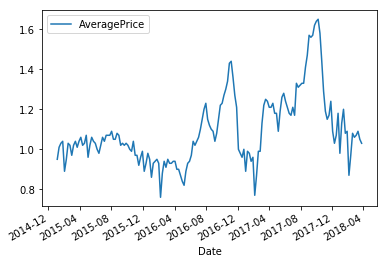

In [16]:
## First, let's take a look at our time series
ax = data.plot('Date', 'AveragePrice', kind='line')

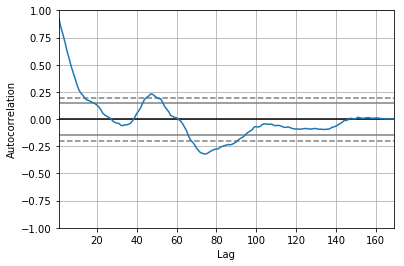

In [17]:
ax = pd.plotting.autocorrelation_plot(data['AveragePrice'])

We can see that the current week's average price is most strongly correlated with the prior ~10 weeks of prices, so let's add in lagged pricing data for the prior 10 weeks. 

In [18]:
data['Date'][9]

Timestamp('2015-03-08 00:00:00')

In [19]:
lagged_price = [ data['AveragePrice'].iloc[10-n:len(data)-n].values for n in np.arange(1,11) ]

In [20]:
lags = [ 'price_lagged_' + str(n) for n in np.arange(1,11) ]

In [21]:
lagged_price_df = pd.DataFrame( { l:p for l, p in zip(lags,lagged_price) } )  

In [22]:
lagged_price_df = lagged_price_df.reset_index(drop=True)

In [23]:
lagged_price_df.head(15)

,price_lagged_1,price_lagged_2,price_lagged_3,price_lagged_4,price_lagged_5,price_lagged_6,price_lagged_7,price_lagged_8,price_lagged_9,price_lagged_10
0,1.02,0.97,1.02,1.03,0.95,0.89,1.04,1.03,1.01,0.95
1,1.04,1.02,0.97,1.02,1.03,0.95,0.89,1.04,1.03,1.01
2,1.01,1.04,1.02,0.97,1.02,1.03,0.95,0.89,1.04,1.03
3,1.04,1.01,1.04,1.02,0.97,1.02,1.03,0.95,0.89,1.04
4,1.06,1.04,1.01,1.04,1.02,0.97,1.02,1.03,0.95,0.89
5,1.02,1.06,1.04,1.01,1.04,1.02,0.97,1.02,1.03,0.95
6,1.03,1.02,1.06,1.04,1.01,1.04,1.02,0.97,1.02,1.03
7,1.07,1.03,1.02,1.06,1.04,1.01,1.04,1.02,0.97,1.02
8,0.96,1.07,1.03,1.02,1.06,1.04,1.01,1.04,1.02,0.97
9,1.02,0.96,1.07,1.03,1.02,1.06,1.04,1.01,1.04,1.02


In [24]:
# Now we chop off the first 10 samples of the data set
data_chopped = data.iloc[10:].copy()

In [25]:
data_chopped.head(15)

,Date,year,AveragePrice,month,week,weeks_before_cdm
10,2015-03-15,2015,1.04,3,11,8
11,2015-03-22,2015,1.01,3,12,7
12,2015-03-29,2015,1.04,3,13,6
13,2015-04-05,2015,1.06,4,14,5
14,2015-04-12,2015,1.02,4,15,4
15,2015-04-19,2015,1.03,4,16,3
16,2015-04-26,2015,1.07,4,17,2
17,2015-05-03,2015,0.96,5,18,1
18,2015-05-10,2015,1.02,5,19,0
19,2015-05-17,2015,1.06,5,20,-1


In [26]:
data_chopped = data_chopped.reset_index(drop=True)

In [27]:
data_chopped.head(15)

,Date,year,AveragePrice,month,week,weeks_before_cdm
0,2015-03-15,2015,1.04,3,11,8
1,2015-03-22,2015,1.01,3,12,7
2,2015-03-29,2015,1.04,3,13,6
3,2015-04-05,2015,1.06,4,14,5
4,2015-04-12,2015,1.02,4,15,4
5,2015-04-19,2015,1.03,4,16,3
6,2015-04-26,2015,1.07,4,17,2
7,2015-05-03,2015,0.96,5,18,1
8,2015-05-10,2015,1.02,5,19,0
9,2015-05-17,2015,1.06,5,20,-1


In [28]:
merged_data = data_chopped.merge( lagged_price_df, left_index=True, right_index=True )

In [29]:
merged_data.head(20)

,Date,year,AveragePrice,month,week,weeks_before_cdm,price_lagged_1,price_lagged_2,price_lagged_3,price_lagged_4,price_lagged_5,price_lagged_6,price_lagged_7,price_lagged_8,price_lagged_9,price_lagged_10
0,2015-03-15,2015,1.04,3,11,8,1.02,0.97,1.02,1.03,0.95,0.89,1.04,1.03,1.01,0.95
1,2015-03-22,2015,1.01,3,12,7,1.04,1.02,0.97,1.02,1.03,0.95,0.89,1.04,1.03,1.01
2,2015-03-29,2015,1.04,3,13,6,1.01,1.04,1.02,0.97,1.02,1.03,0.95,0.89,1.04,1.03
3,2015-04-05,2015,1.06,4,14,5,1.04,1.01,1.04,1.02,0.97,1.02,1.03,0.95,0.89,1.04
4,2015-04-12,2015,1.02,4,15,4,1.06,1.04,1.01,1.04,1.02,0.97,1.02,1.03,0.95,0.89
5,2015-04-19,2015,1.03,4,16,3,1.02,1.06,1.04,1.01,1.04,1.02,0.97,1.02,1.03,0.95
6,2015-04-26,2015,1.07,4,17,2,1.03,1.02,1.06,1.04,1.01,1.04,1.02,0.97,1.02,1.03
7,2015-05-03,2015,0.96,5,18,1,1.07,1.03,1.02,1.06,1.04,1.01,1.04,1.02,0.97,1.02
8,2015-05-10,2015,1.02,5,19,0,0.96,1.07,1.03,1.02,1.06,1.04,1.01,1.04,1.02,0.97
9,2015-05-17,2015,1.06,5,20,-1,1.02,0.96,1.07,1.03,1.02,1.06,1.04,1.01,1.04,1.02


## X, Y Data preparation

In [ ]:
list(merged_data.keys())

In [ ]:
merged_data = merged_data.drop(columns=['Date'])

In [ ]:
target = "AveragePrice"

In [ ]:
# X_price_cols = [ c for c in region_consolidated_df.columns.values if ('AveragePrice' in c) & ('TotalUS' not in c) ]

In [ ]:
X_features = [ c for c in merged_data.columns.values if 'AveragePrice' not in c ]

In [ ]:
X = merged_data[X_features].values
Y = merged_data[target].values.ravel()

# Models

### Random Forest Regressor with Regional Average Prices

In [ ]:
clf_rfn = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1, n_estimators=150))

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
scores_rf = cross_validate(clf_rfn, X, Y, cv=tscv, n_jobs=-1 )

In [ ]:
np.mean(scores_rf['test_score'])

### Linear Regression

In [ ]:
clf_lr = make_pipeline(StandardScaler(), LinearRegression())

In [ ]:
scores_lr = cross_validate(clf_lr, X, Y, cv=tscv, n_jobs=-1)


In [ ]:
np.mean(scores_lr['test_score'])

In [ ]:
scores_lr

### Prophet

Prophet is an open-source procedure developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
# Let's predict the price of conventional avocados using Prophet. 
# To do this, we must define a DataFrame with just the Date and the y-value to be predicted

In [ ]:
cols = ['Date', 'AveragePrice']
df = data[cols]

In [ ]:
df = df.sort_values(['Date'], ascending=[True]).reset_index(drop=True)

In [ ]:
df = df.rename(columns={'Date':'ds', 'AveragePrice':'y'})

In [ ]:
df.head()

In [ ]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False)

In [ ]:
# For storing the model evaluation results
models = []
predictions = []
training_sets = []
testing_sets = []
fit_results = []
scores = []

In [ ]:
for train_tsi, test_tsi in tscv.split(np.arange(len(df))):
    m = Prophet()
    df_train = df.iloc[train_tsi].copy()
    m.fit(df_train)
    df_test = df.iloc[test_tsi].copy()
    future = m.make_future_dataframe(len(test_tsi), freq='W', include_history=True)
    prediction = m.predict(future)
    
    test_subframe = prediction.iloc[test_tsi]
    train_subframe = prediction.iloc[train_tsi]
    rmse = math.sqrt(mean_squared_error(list(df_test['y']),list(test_subframe['yhat'])))
    error_percentage = rmse / np.average(list(df_test['y']))
    bias = mean_absolute_error(list(df_test['y']),list(test_subframe['yhat']))
    accuracy = bias / np.average(list(df_test['y']))
    scores.append( (rmse, error_percentage, bias, accuracy) )
    
    rmse = math.sqrt(mean_squared_error(list(df_train['y']),list(train_subframe['yhat'])))
    error_percentage = rmse / np.average(list(df_train['y']))
    bias = mean_absolute_error(list(df_train['y']),list(train_subframe['yhat']))
    accuracy = bias / np.average(list(df_train['y']))    

    fit_results.append( (rmse, error_percentage, bias, accuracy ) )
    
    models.append(m)
    predictions.append(prediction)
    
    m.plot(prediction, uncertainty=True)
    
    

In [ ]:
tsc

In [ ]:
mean_mse = np.mean( [ scores[i][0] for i in range(len(scores)) ] )

In [ ]:
1 - mean_mse

In [ ]:
clf_prophet = make_pipeline(StandardScaler(), Prophet(daily_seasonality=False, weekly_seasonality=False))

In [ ]:
scores_prophet = cross_validate(clf_prophet, X, Y, cv=tscv, n_jobs=-1)

### XGBoost 

In [ ]:
clf_xgboost = make_pipeline(StandardScaler(), XGBRegressor(n_estimators=1000, learning_rate=0.5, early_stopping_rounds=5))

In [ ]:
scores_xgb = cross_validate(clf_xgboost, X, Y, cv=tscv)

In [ ]:
print("\nXGBoost Model with numerical data only:")
print(f"{round(np.mean(scores_xgb['test_score']),3)*100}% accuracy")


## Ensemble Learning & Model Stacking
In the section above we have demostrated the application of several different models to our time-series data. In the section below, we will retrain these models, this time in the context of ensemble learning. 

In [ ]:
# Define some helper functions
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params=None, seed=0,):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def cross_validate(self, x, y, cv, n_jobs=-1):
        return cross_validate( self.clf, x, y, cv=cv, n_jobs=n_jobs )
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

In [ ]:
def get_oof(clf, cv, x_train, y_train, x_test, n_train):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((n_splits, n_splits)

    for i, (train_index, test_index) in enumerate(cv):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_test)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# Model Parameters
SEED = 0

# Random Forrest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
}
rf_features = [ f for f in X_features if 'AveragePrice' not in f and 'Date' not in f ]

# XG Boost
xgb_params = {
    'n_estimators' : 1000, 
    'learning_rate' : 0.5,
    'early_stopping_rounds' : 5,
}
xgb_features = [ f for f in X_features if 'AveragePrice' not in f and 'Date' not in f ]

Y_features = ['AveragePrice']

To begin, we must split up our data set into train+test and hold-out subsamples. We will use the test+train sample to train the L1 models, and the test and hold-out (or out-of-fold) sets to train and test the aggregator, respectively. 

In [ ]:
n_samples_total = len(data)

In [ ]:
i_train_start = 0
i_test_start = len(data)//3
i_oof_start = 2*len(data)//3

In [ ]:
X_train = merged_data.iloc[i_train_start:i_test_start][X_features].values
Y_train = merged_data.iloc[i_train_start:i_test_start]['AveragePrice'].values
X_test = merged_data.iloc[i_test_start:i_oof_start][X_features].values
Y_test = merged_data.iloc[i_test_start:i_oof_start]['AveragePrice'].values.ravel()
X_oof = merged_data.iloc[i_oof_start:][X_features].values
Y_oof = merged_data.iloc[i_oof_start:]['AveragePrice'].values.ravel()


#### Train the models

In [ ]:
n_splits=5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [ ]:
rf_oof_train, rf_oof_test = get_oof(rf, tscv, X_train, Y_train, X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgb, tscv, X_train, Y_train, X_test)

In [ ]:
## Let's look at feature importance 

In [ ]:
rf_feature = rf.feature_importances(X_train, Y_train)
xgb_feature = xgb.feature_importances(X_train, Y_train)